#### 1) 데이터 불러오기

In [1]:
import torch
import warnings
import time
import random
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm
import matplotlib.pyplot   as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import torch.nn                     as nn
import torch.nn.functional          as F
from   torch.utils.data             import Dataset,DataLoader


# 시드(seed) 고정
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
warnings.filterwarnings(action='ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# 데이터 파일 경로 설정
df = pd.read_csv('C:/Users/symply_jina/Desktop/seohyun/IIE4123/hw3/LSTM_practice/electricity.csv')

In [28]:
# 하이퍼 파라미터 설정
class Parameters():
    def __init__(self):
        self.description = 'LSTM 모델을 이용한 시계열 예측'
        # 입력 시퀀스 길이 - look-back
        self.Lag         = 30
        # 예측 시퀀스 길이
        self.Horizon     = 7

        # 에포크 수
        self.epochs        = 500
        # 배치 크기
        self.batch_size    = 16
        # 학습률
        self.learning_rate = 1e-4 # 0.0001
        # 훈련된 모델 경로
        self.model_name    = 'LSTM'
        # 파일명
        self.filename              = './LSTM_practice/electricity.csv'
        # 대상 시계열 이름
        self.targetSeries          = 'OT'
        # 훈련 세트 비율
        self.TrainingSetPercentage = 0.8
        # 스케일링 {'Standard', 'MinMax', 'Robust'}
        self.Scaling               = 'Standard'


args = Parameters()

In [29]:
# 날짜로 인식하게 수정 후 데이터프레임으로 변환
df['date'] = df['date'].astype('datetime64[ns]')
df.set_index('date', inplace=True)
df = pd.DataFrame( df[ [ args.targetSeries ] ] )
df

,OT
date,
2019-08-21 05:00:00,16.775000
2019-08-21 06:00:00,12.071429
2019-08-21 07:00:00,10.028571
2019-08-21 08:00:00,8.837500
2019-08-21 09:00:00,20.014286
...,...
2022-02-01 17:00:00,50.790909
2022-02-01 18:00:00,53.970000
2022-02-01 19:00:00,52.209091


In [30]:
# 80% 훈련 나머지 테스트
idx = int( df.shape[0] * args.TrainingSetPercentage )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

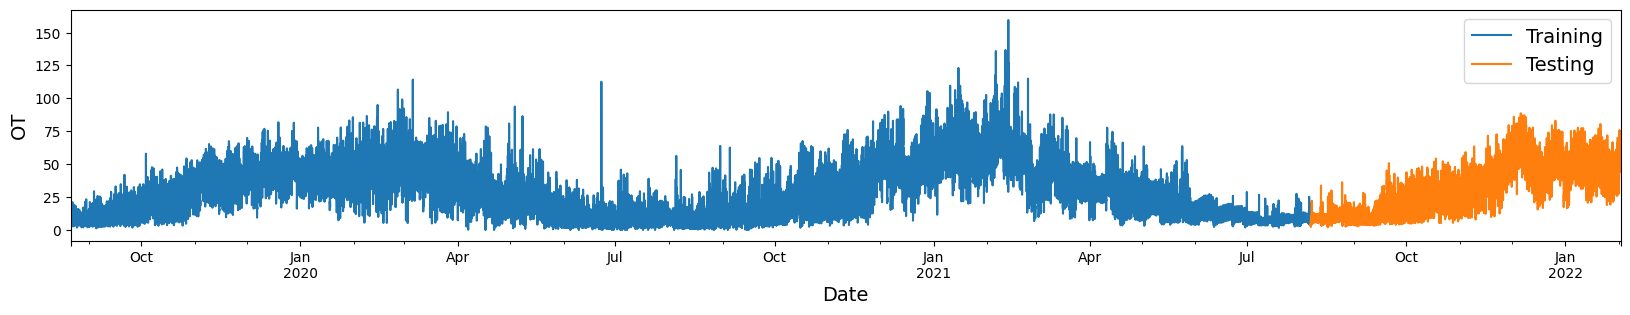

In [31]:
# 학습 및 테스트 데이터 시각화
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train.plot(ax=ax, color='tab:blue' )
df_test.plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], fontsize = 14)
plt.ylabel(args.targetSeries, size = 14);
plt.xlabel('Date', size = 14);

In [32]:
# 테스트 시작시 앞의 과거기간이 필요하므로
# train data의 마지막 날짜로부터 args.Lag 만큼의 데이터를 가져와서 test 앞에 붙임
df_test = pd.concat([df_train.iloc[-args.Lag:], df_test])

In [97]:
if (args.Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')

    scaler = MinMaxScaler()
    df_train[args.targetSeries] = scaler.fit_transform(df_train[args.targetSeries].to_numpy().reshape(-1, 1))
    df_test[args.targetSeries]  = scaler.transform(df_test[args.targetSeries].to_numpy().reshape(-1, 1))

elif (args.Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')


    scaler = RobustScaler()
    df_train[args.targetSeries] = scaler.fit_transform(df_train[args.targetSeries].to_numpy().reshape(-1, 1))
    df_test[args.targetSeries]  = scaler.transform(df_test[args.targetSeries].to_numpy().reshape(-1, 1))

elif (args.Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    scaler = StandardScaler()

    df_train[args.targetSeries] = scaler.fit_transform(df_train[args.targetSeries].to_numpy().reshape(-1, 1))
    df_test[args.targetSeries]  = scaler.transform(df_test[args.targetSeries].to_numpy().reshape(-1, 1))
else:
    print('[WARNING] Unknown data scaling. Standard scaling was selected')

    scaler = StandardScaler()

    df_train[args.targetSeries] = scaler.fit_transform(df_train[args.targetSeries].to_numpy().reshape(-1, 1))
    df_test[args.targetSeries]  = scaler.transform(df_test[args.targetSeries].to_numpy().reshape(-1, 1))

[INFO] Scaling: Standard


In [98]:
def create_dataset(df=None, Lag=1, Horizon=1, targetSeries=None):

    dataX, dataY, dataDate = [], [], []

    # 데이터셋을 생성하기 위한 루프, 0에서 시작해서 데이터프레임의 길이 - Lag - Horizon까지 반복
    for i in tqdm(range(0, df.shape[0] + 1 - Lag - Horizon)):
        # 입력 시퀀스를 dataX에 추가
        dataX.append(df.to_numpy()[i:(i + Lag)])
        # 타겟 시퀀스를 dataY에 추가
        dataY.append(df[targetSeries].to_numpy()[i + Lag : i + Lag + Horizon])
        # 타겟 시퀀스의 날짜를 dataDate에 추가
        dataDate.append(df.index[i + Lag : i + Lag + Horizon].tolist())

    # numpy 배열로 변환하여 반환
    return (np.array(dataX), np.array(dataY), np.array(dataDate))

In [99]:
print(args.Lag, args.Horizon)

30 7


In [100]:
trainX, trainY, _ = create_dataset(df           = df_train,
                                   Lag          = args.Lag,
                                   Horizon      = args.Horizon,
                                   targetSeries = args.targetSeries)


testX,  testY, testDate  = create_dataset(df           = df_test,
                                          Lag          = args.Lag,
                                          Horizon      = args.Horizon,
                                          targetSeries = args.targetSeries)

100%|██████████| 4294/4294 [00:00<00:00, 19306.85it/s]


In [101]:
# 훈련 데이터의 마지막 10%를 검증용으로 사용
#
# 훈련 데이터에서 검증 데이터로 나누는 인덱스를 계산
idx = int(0.9 * trainX.shape[0])

# 검증 데이터셋을 생성 (마지막 10%)
validX, validY = trainX[idx:], trainY[idx:]

# 훈련 데이터셋을 생성 (처음 90%)
trainX, trainY = trainX[:idx], trainY[:idx]
trainY = np.expand_dims(trainY, axis = -1)
validY = np.expand_dims(validY, axis = -1)
testY  = np.expand_dims(testY,  axis = -1)

# 훈련 데이터셋의 형태 출력
print('Training data shape:   ', trainX.shape, trainY.shape)
# 검증 데이터셋의 형태 출력
print('Validation data shape: ', validX.shape, validY.shape)
# 테스트 데이터셋의 형태 출력
print('Testing data shape:    ', testX.shape,  testY.shape)

Training data shape:    (15444, 30, 1) (15444, 7, 1)
Validation data shape:  (1717, 30, 1) (1717, 7, 1)
Testing data shape:     (4294, 30, 1) (4294, 7, 1)


In [102]:
import torch
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self, X, Y):
        # 데이터를 torch.tensor로 변환하고 데이터 타입을 float32로 설정
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# 훈련 및 테스트 데이터로더 생성
#
train_ds = Data(trainX, trainY)
valid_ds = Data(validX, validY)
test_ds  = Data(testX,  testY)

# 데이터 로더 준비
#
train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=args.batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=args.batch_size, shuffle=False)

#### 2) LSTM

In [103]:
import torch.nn as nn
import torch

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_length=24):
        """
        LSTM 모델 초기화

        Args:
            input_size (int): 각 시간 단계별 입력 특징 수. 단일 채널의 경우 1.
            hidden_size (int): 은닉 상태의 특징 수.
            num_layers (int): 순환 레이어 수.
            output_length (int): 출력 시퀀스 길이.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.output_length = output_length
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # batch_first=True: (batch_size, seq_len, input_size) 형태의 입력
        self.fc = nn.Linear(hidden_size, output_length)  # 최종 출력

    def forward(self, x):

        # 초기 은닉 상태 (h0) 및 셀 상태 (c0)를 0으로 초기화
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.hidden_size).to(device)

        # LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, 입력길이, hidden_size)


       # 마지막 시간 단계의 h만 추출하여 fc 통과
        out = self.fc(out[:, -1, :])  # out: (batch_size, output_length)

        return out.unsqueeze(2)  # out: (batch_size, output_length, 1) 형태로 변환


In [104]:
# 모델 생성해서 데이터 넣어보기
model = LSTM(input_size=1, hidden_size=50, num_layers=3, output_length=args.Horizon).to(device)


# 랜덤 입력값 생성 (예: 배치 크기 32, 입력 길이)
input_data = torch.randn(32, args.Lag, 1).to(device)

# 모델 실행 및 출력 확인
output = model(input_data)
print(f"Output shape: {output.shape}")  # (32, 입력 길이, 1) 형태의 출력

Output shape: torch.Size([32, 7, 1])


#### 3) 학습

In [105]:
from EarlyStopping      import *
from LRScheduler        import *


model = LSTM(input_size=1, hidden_size=50, num_layers=3, output_length=args.Horizon).to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(params = model.parameters(),
                             lr     = args.learning_rate)


early_stopping = EarlyStopping(patience  = 10,
                               min_delta = 1e-5)


scheduler = LRScheduler(optimizer = optimizer,
                        patience  = 3,
                        min_lr    = 1e-10,
                        factor    = 0.5)

In [69]:
# 훈련 및 검증 손실 저장
Loss = {
         'Train': [],
         'Valid':  []
       }

# 메인 루프 - 훈련 과정
for epoch in range(1, args.epochs+1):

    # 타이머 시작
    start = time.time()

    # 훈련 손실 모니터링
    train_loss = 0.0
    valid_loss  = 0.0

    ###################
    # 모델 훈련하기 #
    ###################

    for data, target in train_dl:

        #  기울기 초기화
        optimizer.zero_grad()

        data   = data.cuda()
        target = target.cuda()

        outputs = model(data)
        outputs = outputs
        # 손실 계산

        loss = criterion(outputs, target)

        # 기울기 계산
        loss.backward()

        # 업데이트
        optimizer.step()

        train_loss += loss.item() * data.size(0)


    train_loss = train_loss / train_dl.dataset.X.shape[0]

    with torch.no_grad():
        for data, target in valid_dl:

            data   = data.cuda()
            target = target.cuda()

            outputs = model(data)

            # 손실 계산
            loss = criterion(outputs, target)

            # 실행 중인 검증 손실 업데이트
            valid_loss += loss.item() * data.size(0)

    # 평균 훈련 통계 출력
    valid_loss = valid_loss / test_dl.dataset.X.shape[0]

    # 타이머 정지
    stop = time.time()

    # 훈련 결과 출력
    print('\n[INFO] Epoch: {} \tTrain Loss: {:.6f}\tValid Loss: {:.6f} \tTime: {:.2f}secs'.format(epoch, train_loss, valid_loss, stop-start), end=' ')

    # 최적 모델 업데이트
    if (epoch == 1):
        Best_score = valid_loss

        torch.save(model.state_dict(), "./" + args.model_name + ".pth")
        print('(모델 저장됨)\n')
    else:
        if (Best_score > valid_loss):
            Best_score = valid_loss

            torch.save(model.state_dict(), "./" + args.model_name + ".pth")
            print('(모델 저장됨)\n')
        else:
            print('\n')

    # 훈련/검증 손실 저장
    Loss['Train'] += [train_loss]
    Loss['Valid'] += [valid_loss]

    # 학습률 스케줄러
    scheduler(valid_loss)

    # 조기 종료
    if (early_stopping(valid_loss)):
        break


[INFO] Epoch: 1 	Train Loss: 0.472567	Valid Loss: 0.019550 	Time: 3.70secs (모델 저장됨)


[INFO] Epoch: 2 	Train Loss: 0.352153	Valid Loss: 0.019425 	Time: 3.73secs (모델 저장됨)


[INFO] Epoch: 3 	Train Loss: 0.348033	Valid Loss: 0.019387 	Time: 5.12secs (모델 저장됨)


[INFO] Epoch: 4 	Train Loss: 0.346451	Valid Loss: 0.019147 	Time: 3.67secs (모델 저장됨)


[INFO] Epoch: 5 	Train Loss: 0.344950	Valid Loss: 0.019260 	Time: 3.64secs 


[INFO] Epoch: 6 	Train Loss: 0.343937	Valid Loss: 0.020095 	Time: 4.39secs 


[INFO] Epoch: 7 	Train Loss: 0.343268	Valid Loss: 0.019181 	Time: 4.29secs 


[INFO] Epoch: 8 	Train Loss: 0.341231	Valid Loss: 0.019397 	Time: 3.69secs 


[INFO] Epoch: 9 	Train Loss: 0.335789	Valid Loss: 0.019560 	Time: 3.67secs 


[INFO] Epoch: 10 	Train Loss: 0.328791	Valid Loss: 0.019158 	Time: 5.01secs 


[INFO] Epoch: 11 	Train Loss: 0.322041	Valid Loss: 0.018960 	Time: 3.68secs (모델 저장됨)


[INFO] Epoch: 12 	Train Loss: 0.316601	Valid Loss: 0.018589 	Time: 3.70secs (모델 저장됨)


[INFO] Epoch

In [106]:
# Load best model # 미리 사전훈련한 가중치를 불러와도됨, 주의할점은 모델은 사전훈련했던 모델과 똑같은 구조여야 가중치를 로드할수있음

# 방금 학습에서 가장 낮은 valid loss를 가졌던 epoch의 가중치를 불러오기
model = LSTM(input_size=1, hidden_size=50, num_layers=3, output_length=args.Horizon).to(device)

#model.load_state_dict( torch.load( "./" + args.model_name + ".pth"  ,weights_only=True) )
model.load_state_dict( torch.load( "./" + "LSTM_pretrained.pth" ) )

model.eval()

print('[INFO] Model loaded')

[INFO] Model loaded


In [107]:
# 테스트 데이터 예측
pred = None
with torch.no_grad():
    for data, target in tqdm( test_dl ):
        data   = data.to( device )
        target = target.to( device )
        if pred is None:
            pred = model(data).cpu().numpy()  # 처음 예측 값을 NumPy 배열로 변환
        else:
            pred = np.concatenate([pred, model(data).cpu().numpy()])  # 이후 예측 값들을 연결

100%|██████████| 269/269 [00:00<00:00, 1000.87it/s]


In [108]:
# Reshaping
testY_ = testY.squeeze(-1) # 마지막 차원 제거
pred  = pred.squeeze(-1) # 마지막 차원 제거

In [109]:
testY_.shape

(4294, 7)

In [110]:
pred.shape

(4294, 7)

In [111]:
# Inverse scaling
#
for i in range( args.Horizon ):
    testY_[:,  i] = scaler.inverse_transform( testY_[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)

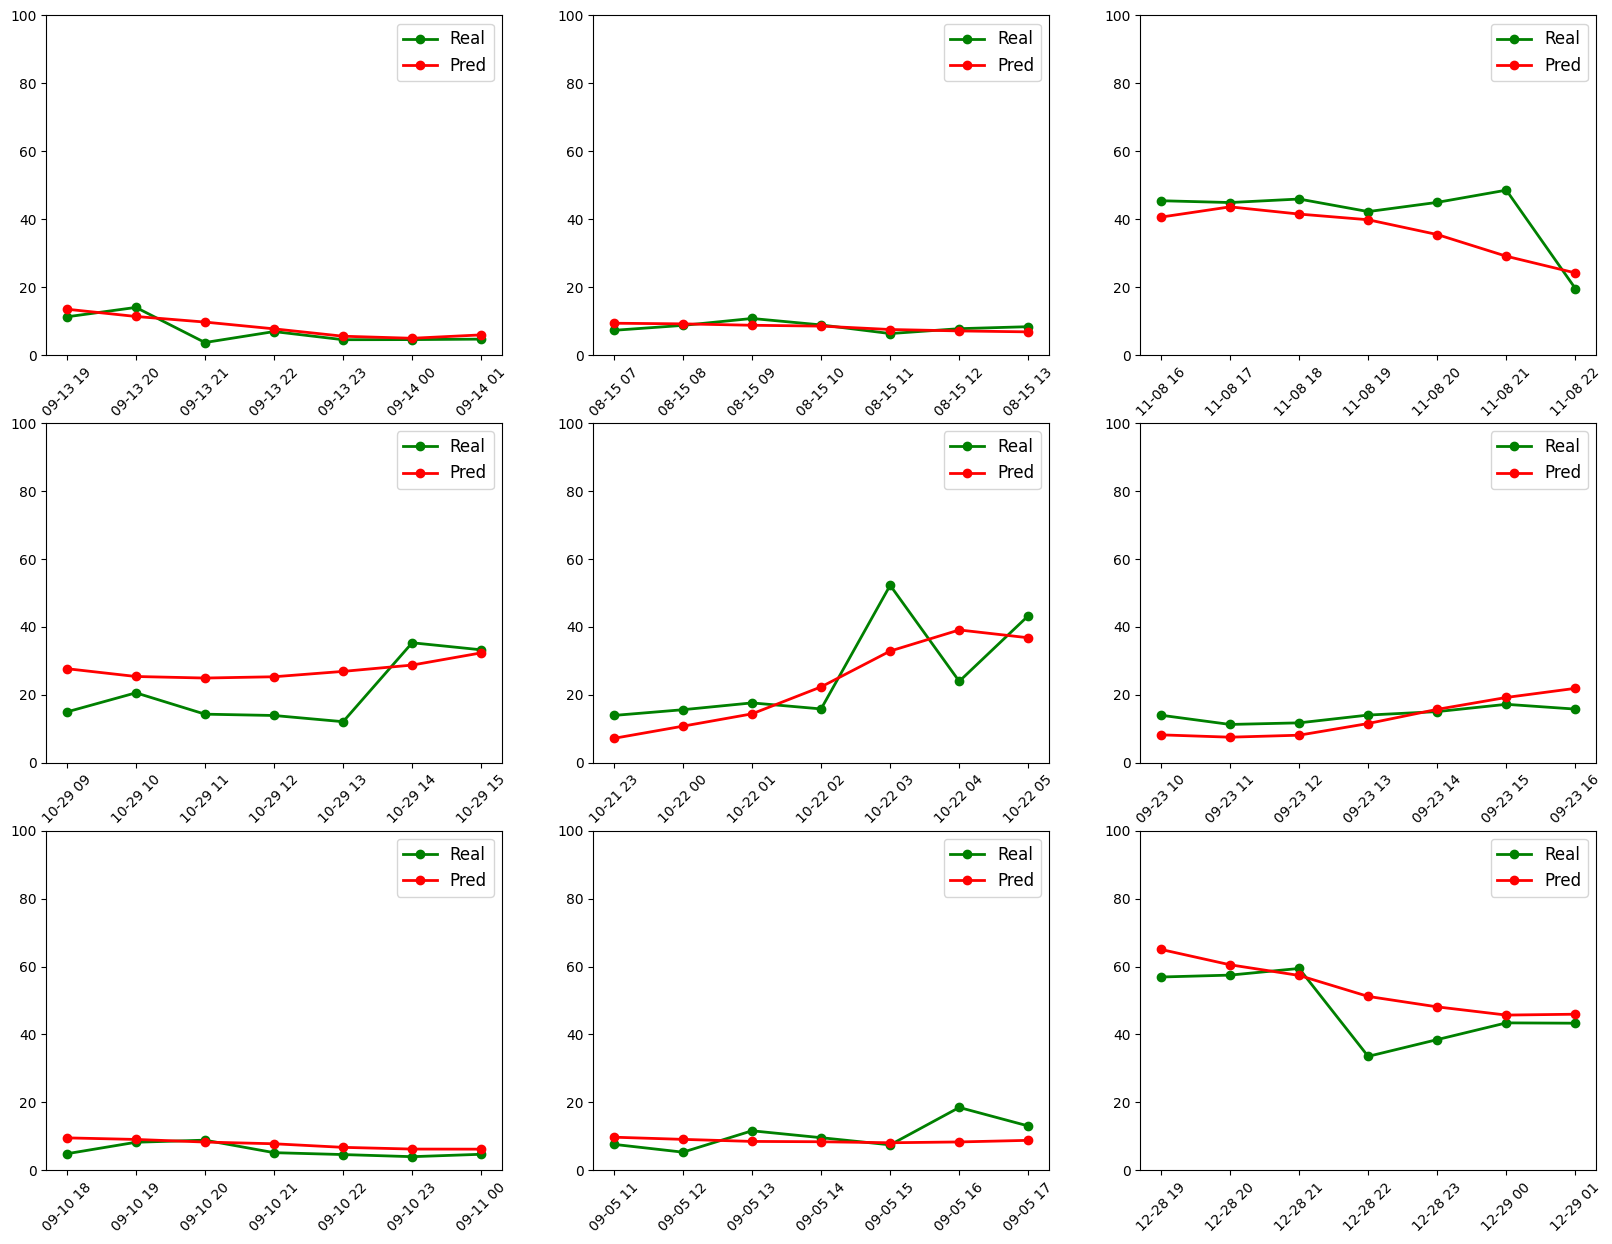

In [112]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]


plt.figure(figsize=(20, 15))

# 랜덤 케이스 선택 (9개만)
RandomInstances = [random.randint(1, testY_.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.plot(testDate[i], testY_[i], color='g', marker='o', linewidth=2)
    plt.plot(testDate[i], pred[i], color='r', marker='o', linewidth=2)

    plt.legend(['Real', 'Pred'], fontsize=12)
    plt.ylim([0, 100])
    plt.xticks(rotation=45)
plt.show()

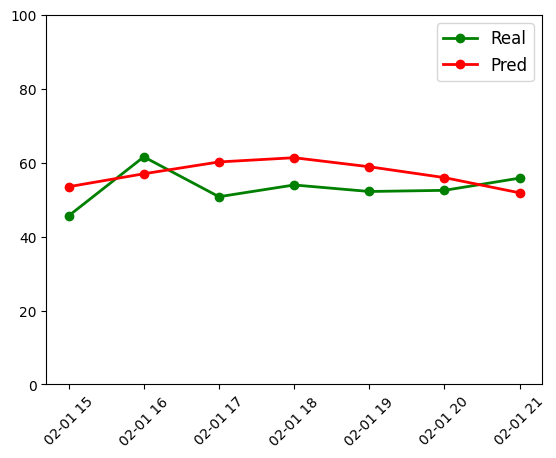

In [113]:
# 가장 최근 예측

plt.plot(testDate[-1], testY_[-1], color='g', marker='o', linewidth=2)
plt.plot(testDate[-1], pred[-1], color='r', marker='o', linewidth=2)

plt.legend(['Real', 'Pred'], fontsize=12)
plt.ylim([0, 100])
plt.xticks(rotation=45)
plt.show()
